In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import string
import pickle
import emoji
import scipy.stats as ss
import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import nltk
nltk.download('omw-1.4')
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

%matplotlib inline

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kamen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
lemmatizer = WordNetLemmatizer()
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

#Convert emojis to words 
with open('Emoji_Dict.p', 'rb') as fp:
        Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(mess):
    for emot in Emoji_Dict:
        mess = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), mess)
    return mess

def text_process(mess):
    
    #Convert emojis to words
    mess = convert_emojis_to_word(mess)
    mess = mess.lower() # lowercase text
    mess = REPLACE_BY_SPACE_RE.sub('', mess) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    mess = BAD_SYMBOLS_RE.sub('', mess)

    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    stop = ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

    return stop

In [3]:
text_process('Hello, my name is Kamen. I hope you have a good day.')

'hello name kamen hope good day'

In [4]:
#A NEW DAY, NEW OPPORTUNITY
df_tr = pd.read_csv('train.txt',sep=';')
df_tr.rename({'i didnt feel humiliated':'text','sadness':'label'}, axis = 1, inplace=True)
df_v = pd.read_csv('val.txt', sep=';')
df_v.rename({'im feeling quite sad and sorry for myself but ill snap out of it soon':'text','sadness':'label'}, axis = 1, inplace=True)
df_te = pd.read_csv('test.csv', sep=';')
df_te.rename({'im feeling rather rotten so im not very ambitious right now':'text','sadness':'label'}, axis = 1, inplace=True)

In [5]:
df_te

,text,label
0,im updating my blog because i feel shitty,sadness
1,i never make her separate from me because i do...,sadness
2,i left with my bouquet of red and yellow tulip...,joy
3,i was feeling a little vain when i did this one,sadness
4,i cant walk into a shop anywhere where i do no...,fear
...,...,...
1994,i just keep feeling like someone is being unki...,anger
1995,im feeling a little cranky negative after this...,anger
1996,i feel that i am useful to my people and that ...,joy
1997,im feeling more comfortable with derby i feel ...,joy


In [6]:
print('Training data length: ', len(df_tr))
print('Validation data length: ', len(df_v))
print('Testing data length: ', len(df_te))

Training data length:  15999
Validation data length:  1999
Testing data length:  1999


In [7]:
#LSTM
from keras.utils.data_utils import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional

In [8]:
dfs = [df_tr, df_v, df_te]
for df in dfs:
    print('Processing text data')
    df['to_check'] = df['text'].apply(text_process)
    print('Encoding y values')
    df['label']=df['label'].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
    print('\n')

Processing text data


In [ ]:
df_te.head()

,text,label,to_check
0,im updating my blog because i feel shitty,3,im updating blog feel shitty
1,i never make her separate from me because i do...,3,never make separate ever want feel like ashamed
2,i left with my bouquet of red and yellow tulip...,0,left bouquet red yellow tulips arm feeling sli...
3,i was feeling a little vain when i did this one,3,feeling little vain one
4,i cant walk into a shop anywhere where i do no...,4,cant walk shop anywhere feel uncomfortable


In [ ]:
X_tr = df_tr['to_check'].values
y_tr = df_tr['label'].values
X_v = df_v['to_check'].values
y_v = df_v['label'].values
X_te = df_te['to_check'].values
y_te = df_te['label'].values
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)
print('Training data shape: ',X_tr.shape,y_tr.shape)
print('Validation data shape: ',X_v.shape,y_v.shape)
print('test data shape: ',X_te.shape,y_te.shape)

Training data shape:  (15999,) (15999,)
Validation data shape:  (1999,) (1999,)
test data shape:  (1999,) (1999,)


In [ ]:
#Prepare parameters
n_words = 20000 # cut texts after this 
maxlen = 80
batch_size = 128 

In [ ]:
tokenizer = Tokenizer(num_words=n_words, lower=True)
tokenizer.fit_on_texts(X_tr)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15064 unique tokens.


In [ ]:
X_tr = tokenizer.texts_to_sequences(X_tr)
X_tr = pad_sequences(X_tr, maxlen=maxlen)
print('Shape of data tensor:', X_tr.shape)

Shape of data tensor: (15999, 80)


In [ ]:
#One Hot Encoding Training data
y_tr=to_categorical(y_tr)
y_tr

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
#X_test
X_v = tokenizer.texts_to_sequences(X_v)
X_v = pad_sequences(X_v, maxlen=maxlen)

In [ ]:
#One Hot Encode validation data
y_v = to_categorical(y_v)

In [ ]:
#LSTM Model creation
model=Sequential()
model.add(Embedding(15185,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 64)            971840    
                                                                 
 dropout (Dropout)           (None, 80, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          92800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 320)              410880    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1926      
                                                                 
Total params: 1,477,446
Trainable params: 1,477,446
Non-

In [ ]:
hist=model.fit(X_tr,y_tr,epochs=12,validation_data=(X_v,y_v))

Epoch 1/12
500/500 [==============================] - 608s 1s/step - loss: 1.1409 - accuracy: 0.5607 - val_loss: 0.6171 - val_accuracy: 0.7999
Epoch 2/12
500/500 [==============================] - 646s 1s/step - loss: 0.4354 - accuracy: 0.8480 - val_loss: 0.2868 - val_accuracy: 0.9010
Epoch 3/12
500/500 [==============================] - 634s 1s/step - loss: 0.2485 - accuracy: 0.9146 - val_loss: 0.2227 - val_accuracy: 0.9160
Epoch 4/12
500/500 [==============================] - 809s 2s/step - loss: 0.1803 - accuracy: 0.9359 - val_loss: 0.2121 - val_accuracy: 0.9185
Epoch 5/12
500/500 [==============================] - 641s 1s/step - loss: 0.1287 - accuracy: 0.9520 - val_loss: 0.2050 - val_accuracy: 0.9245
Epoch 6/12
500/500 [==============================] - 658s 1s/step - loss: 0.1110 - accuracy: 0.9586 - val_loss: 0.2013 - val_accuracy: 0.9260
Epoch 7/12
500/500 [==============================] - 644s 1s/step - loss: 0.0858 - accuracy: 0.9682 - val_loss: 0.1907 - val_accuracy: 0.9230

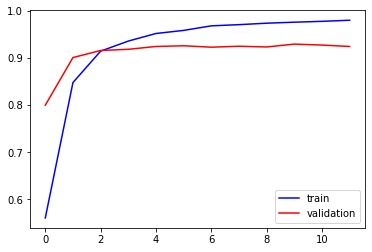

In [ ]:
"""
IMPORTANT:
Training data has to come from train.txt
Validation data has to come from val.txt
Test data has to from test.txt
"""
import matplotlib.pyplot as plt 
%matplotlib inline
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

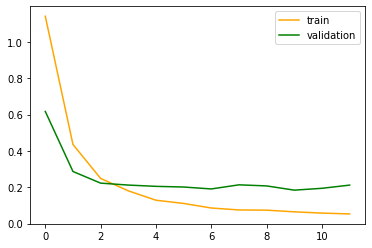

In [ ]:
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Let's test the model
X_te = tokenizer.texts_to_sequences(X_te)
X_te = pad_sequences(X_te, maxlen=maxlen)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [ ]:
y_te = to_categorical(y_te)

In [ ]:
X_te.shape

(1999, 80)

In [ ]:
model.evaluate(X_te,y_te)

63/63 [==============================] - 5s 73ms/step - loss: 0.2039 - accuracy: 0.9330


[0.20386932790279388, 0.9329664707183838]

In [ ]:
y_pred=model.predict(X_te)

63/63 [==============================] - 5s 83ms/step


In [ ]:
y_pred[1]

array([1.8279141e-04, 1.0477126e-04, 1.5328704e-05, 9.9965239e-01,
       2.9339342e-05, 1.5382535e-05], dtype=float32)

In [ ]:
plot_confusion_matrix(y_te, np.argmax(y_pred,axis=1)))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
print(classification_report(y_te,np.argmax(y_pred,axis=1)))

TypeError: classification_report() got an unexpected keyword argument 'X'